In [1]:
# anomaly detection using PCA, Mahalanobis Distance and Autoencoder
# detect gear bearing degradation adapted from Michio JP

import os
import pandas as pd, numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import set_random_seed
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential, load_model, model_from_json
from keras import regularizers

Using TensorFlow backend.


In [2]:
# data load
data_dir ='/Users/mathewlong/Documents/FAIM_Data/DataScienceHandBook/IMS/2nd_test'
merged_df = pd.DataFrame()

for filename in os.listdir(data_dir):
    #print(filename)
    df = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    df_mean_abs = np.array(df.abs().mean())
    df_mean_abs = pd.DataFrame(df_mean_abs.reshape(1,4))
    df_mean_abs.index = [filename]
    merged_df = merged_df.append(df_mean_abs);

merged_df.columns = ['Bearing_1', 'Bearing_2','Bearing_3','Bearing_4']

In [3]:
# after loading vibration data, transform index to datetime format, sort data by index, save as csv
merged_df.index = pd.to_datetime(merged_df.index, format='%Y.%m.%d.%H.%M.%S')
merged_df = merged_df.sort_index()
merged_df.to_csv('merged_df_bearing2.csv')
merged_df.head()

,Bearing_1,Bearing_2,Bearing_3,Bearing_4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [4]:
# initial exploratory analysis
merged_df.describe()

,Bearing_1,Bearing_2,Bearing_3,Bearing_4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


In [5]:
# create training and testing sets
data_train = merged_df[:-550]
data_test = merged_df[-550:]

In [6]:
# confirm dimensions
print(data_train.shape, data_test.shape)

(434, 4) (550, 4)


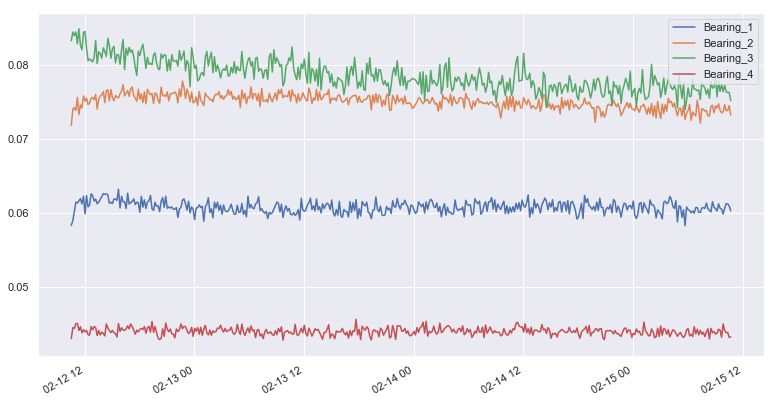

In [7]:
# plot raw data
data_train.plot(figsize=(13,7))

In [8]:
# scale the data b/w 0 -1 with minmaxscaler()
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)

# random shuffle training data with 100% replacement
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns, index=data_test.index)

In [9]:
# PCA for anomaly detection
# reduce diminsions to two main principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

PCA_X_train = pca.fit_transform(X_train)
PCA_X_train = pd.DataFrame(PCA_X_train)
PCA_X_train.index = X_train.index

PCA_X_test = pca.transform(X_test)
PCA_X_test = pd.DataFrame(PCA_X_test)
PCA_X_test.index = X_test.index

In [10]:
# mahalanobis distince metric good for cluster analysis and classification techniques
# 
# calculate covariance matrix
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print('Error: Inverse of covariance matrix is not positive definite!')
            
# calculate mahalanobis distance
def Mahalanobis(inv_cov_matrix, mean_dist, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_dist
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    
    return md

In [11]:
# detecting outliers
def MD_detect(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i) # index of outlier
    
    return np.array(outliers)

In [12]:
# define threshold for classifying datapoint as outlier
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold


In [13]:
# check if matrix is positive definite

def is_pos_def(A):
    if np.allclose(A,A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [14]:
# define train/test set from two main principal components
data_train = np.array(PCA_X_train.values)
data_test = np.array(PCA_X_test.values)

In [15]:
cov_matrix, inv_cov_matrix = cov_matrix(data_train)

# calculate the mean value for input variables for mahalanobis distance
mean_dist = data_train.mean(axis=0)

# using covariance and inv_cov, calculate mahalanobis dist for normal conditions and find threshold value to flag datapoints
dist_test = Mahalanobis(inv_cov_matrix, mean_dist, data_test, verbose=False)
dist_train = Mahalanobis(inv_cov_matrix, mean_dist, data_train, verbose=False)

threshold = MD_threshold(dist_train, extreme=True)

(0.0, 15)

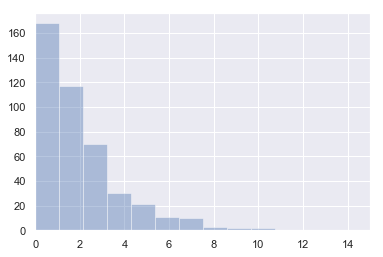

In [16]:
# plot chi squared distribution, then plot mahalanobis distance, should follow chi squared
plt.figure()
sns.distplot(np.square(dist_train), bins=10, kde=False)
plt.xlim([0.0,15])

3.8138278690450207


/Users/mathewlong/miniconda3/envs/faim-tf/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


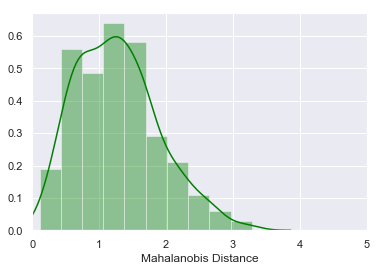

In [17]:
plt.figure()
sns.distplot(dist_train, bins=10, kde=True, color='green')
plt.xlim([0.0, 5])
plt.xlabel('Mahalanobis Distance')
print(threshold)

In [18]:
# distribution above, calculated threshold value of ~3.819 for flagging an anomaly
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold

# if Mob distance above threshold, Flag anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = PCA_X_train.index

anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold
# if Mob distance above threshold, Flag anomaly

anomaly['Anomaly'] = anomaly['Mob dist'] >= anomaly['Thresh']
#anomaly.index = X_train_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
0,0.791547,3.813828,False
1,0.728683,3.813828,False
2,1.878058,3.813828,False
3,1.705319,3.813828,False
4,2.114261,3.813828,False


In [19]:
# merge data into single dataframe and save as csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

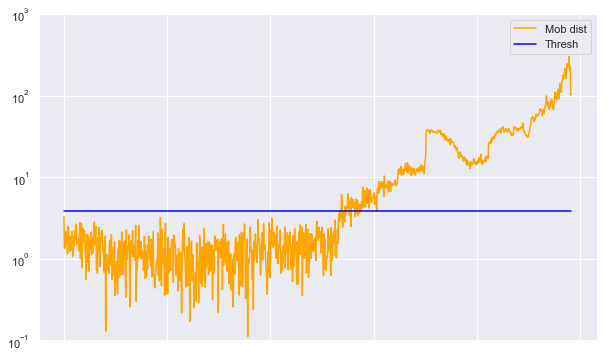

In [20]:
anomaly_alldata.plot(logy=True, figsize=(10,6), ylim= [1e-1, 1e3], color =['orange','blue'])

In [21]:
# anomaly detection with an autoencoder network
np.random.seed(10)
set_random_seed(10)
act_func ='elu'

# input layer
model = Sequential()
#first hidden layer, connected to input vector X
model.add(Dense(10,activation=act_func, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0),
               input_shape=(X_train.shape[1],)))
model.add(Dense(2, activation=act_func, kernel_initializer='glorot_uniform'))
model.add(Dense(10, activation=act_func, kernel_initializer='glorot_uniform'))
model.add(Dense(X_train.shape[1], kernel_initializer='glorot_uniform'))
model.compile(loss='mse', optimizer='adam')

In [22]:
# train model for 1200 epochs , batch size of 20
NUM_EPOCHS=1200
BATCH_SIZE=20

In [23]:
history = model.fit(np.array(X_train), np.array(X_train), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.05,
                   verbose=0)

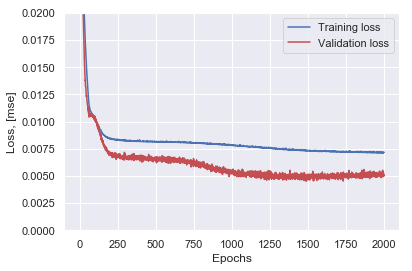

In [24]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.02])
plt.show()

/Users/mathewlong/miniconda3/envs/faim-tf/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0, 0.13)

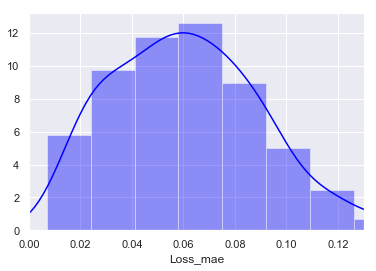

In [25]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.13])

In [26]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head(10)

,Loss_mae,Threshold,Anomaly
2004-02-15 10:52:39,0.064959,0.3,False
2004-02-15 11:02:39,0.109699,0.3,False
2004-02-15 11:12:39,0.099680,0.3,False
2004-02-15 11:22:39,0.064914,0.3,False
2004-02-15 11:32:39,0.113744,0.3,False
2004-02-15 11:42:39,0.082773,0.3,False
2004-02-15 11:52:39,0.065089,0.3,False
2004-02-15 12:02:39,0.079057,0.3,False
2004-02-15 12:12:39,0.028031,0.3,False
2004-02-15 12:22:39,0.068222,0.3,False
